# Trabajo Práctico N°3: Regularización aplicada a la EPH
Federico Di Carlo y Agustin Musso

Importamos las librerías y los comandos que utilizaremos para el desarrollo de las consignas.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn import svm, tree
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import warnings
warnings.filterwarnings('ignore')
# imports the models
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
# imports the metrics
from sklearn.metrics import (RocCurveDisplay, accuracy_score, confusion_matrix,
                             mean_squared_error, plot_roc_curve, roc_auc_score,
                             roc_curve)

# imports the metrics
from time import sleep
from tqdm.notebook import tqdm

## Parte I: Análisis de la base de hogares y cálculo de pobreza

Ahora que ya se han familiarizado con la Encuesta Permanente de Hogares (EPH) y con el uso de la tabla de adulto equivalente vamos a complejizar un poco la construcción del indice de pobreza. Lo calcularemos a nivel de hogares, con sus respectivos factores de expansión y realizaremos una limpieza de la base con mayor dedicación. A continuación complementaremos el trabajo hecho en el TP2 usando la encuesta a nivel de hogares de la EPH: 

1. Exploren el diseño de registro de la base de hogar: a priori, ¿qué variables creen que pueden ser muy predictivas de pobreza y que sería muy útil incluir para perfeccionar el ejercicio del TP2? 

2. Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2021 (la base de hogares se llama `usu_hogar_T121.xls`). Importen los datos de la encuesta de hogar y al igual que en el TP1 conserven sólo las observaciones que corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o del Gran Buenos Aires 

In [2]:
base_hogar = pd.read_excel('usu_hogar_T121.xlsx')
base_hogar

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,AGLOMERADO,PONDERA,IV1,...,GDECCFR,PDECCFR,ADECCFR,PONDIH,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNOQUPHMKKUCDEOJAH00701956,2021,1,1,1,44,N,93,77,1,...,NaN,12.0,12.0,0,96,0,98,0,0,0
1,TQRMNOPWXHMOKRCDEGLDF00701361,2021,1,1,1,41,N,15,140,1,...,NaN,6.0,8.0,191,2,0,3,5,6,0
2,TQRMNOSUXHMMLPCDEGPDJ00701412,2021,1,1,1,40,N,19,177,1,...,NaN,7.0,8.0,177,3,0,4,6,0,0
3,TQRMNORRQHKMKPCDEFOCD00653036,2021,1,1,1,41,N,8,136,1,...,NaN,2.0,3.0,132,2,0,3,0,0,0
4,TQRMNOPYYHMKKRCDEHIBB00699594,2021,1,1,1,40,N,22,175,1,...,NaN,7.0,8.0,205,1,2,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15418,TQRMNOSRSHJLKNCDEHNHB00686513,2021,1,72,1,42,N,27,496,1,...,9.0,NaN,10.0,497,1,0,98,0,0,0
15419,TQRMNOPUPHMOKRCDEHNHB00698996,2021,1,51,1,42,N,27,238,1,...,8.0,NaN,9.0,240,97,0,98,0,0,0
15420,TQRMNOPPTHKKKRCDEHPJB00655306,2021,1,71,1,40,S,29,527,1,...,7.0,NaN,8.0,664,1,0,98,0,0,0
15421,TQRMNOSTVHLKSQCDEIJAH00651298,2021,1,51,1,1,S,33,1673,1,...,8.0,NaN,8.0,2016,1,0,98,0,0,0


Aqui deshacemos las observaciones que no pertenecen a los aglomerados de la Ciudad de Buenos Aires o de la Provincia de Buenos Aires

In [3]:
base_hogar.drop(base_hogar[base_hogar['AGLOMERADO'] < 32.0].index, inplace=True)
base_hogar.drop(base_hogar[base_hogar['AGLOMERADO'] > 33.0].index, inplace=True)
print(base_hogar)

                              CODUSU  ANO4  TRIMESTRE  NRO_HOGAR  REALIZADA  \
15     TQRMNOQXUHJMMUCDEIJAH00693031  2021          1          1          1   
21     TQRMNOSRPHLLNRCDEIJAH00651171  2021          1          1          1   
24     TQRMNOPVUHKLMNCDEIIAD00655817  2021          1          1          1   
36     TQRMNORYTHLOPMCDEIJAH00655933  2021          1          1          1   
43     TQRMNOQPVHLMNNCDEIIAD00650542  2021          1          1          1   
...                              ...   ...        ...        ...        ...   
15373  TQRMNOQYSHMOLTCDEIJAH00700276  2021          1          1          1   
15382  TQRMNOURVHMNONCDEIIAD00700616  2021          1          1          1   
15391  TQRMNORRWHJMOPCDEIIAD00690119  2021          1          1          1   
15412  TQRMNOQWRHLOMPCDEIJAH00650932  2021          1          1          1   
15421  TQRMNOSTVHLKSQCDEIJAH00651298  2021          1         51          1   

       REGION MAS_500  AGLOMERADO  PONDERA  IV1  ..

In [4]:
base_individuos = pd.read_excel('usu_individual_T121.xlsx')
base_individuos.drop(base_individuos[base_individuos['AGLOMERADO'] < 32.0].index, inplace=True)
base_individuos.drop(base_individuos[base_individuos['AGLOMERADO'] > 33.0].index, inplace=True)
print(base_individuos)

                              CODUSU  ANO4  TRIMESTRE  NRO_HOGAR  COMPONENTE  \
36799  TQRMNOPPRHKMLNCDEIIAD00655703  2021          1          1           1   
36800  TQRMNOPPRHKMLNCDEIIAD00655703  2021          1          1           2   
36801  TQRMNOPPWHKMNUCDEIIAD00655837  2021          1          1           1   
36802  TQRMNOPPWHKMNUCDEIIAD00655837  2021          1          1           2   
36803  TQRMNOPPWHKMNUCDEIIAD00655837  2021          1          1           3   
...                              ...   ...        ...        ...         ...   
40876  TQUMNOQWTHLOTOCDEIJAH00698524  2021          1          1           2   
40877  TQUMNORVRHMMLLCDEIJAH00698180  2021          1          1           1   
40878  TQUMNORVRHMMLLCDEIJAH00698180  2021          1          1           2   
40879  TQUMNORVRHMMLLCDEIJAH00698180  2021          1          1           3   
40880  TQVMNOPYPHLOTOCDEIJAH00693364  2021          1          2           1   

       H15  REGION MAS_500  AGLOMERADO 

3. Unan la tabla de la encuesta individual con la de la encuesta de hogar.

In [5]:
import pandas as pd
base_merge= pd.merge(base_hogar, base_individuos,
                     on = "CODUSU",how = "inner")

pd.set_option('display.max_columns', None) 
display(base_merge)

,CODUSU,ANO4_x,TRIMESTRE_x,NRO_HOGAR_x,REALIZADA,REGION_x,MAS_500_x,AGLOMERADO_x,PONDERA_x,IV1,IV1_ESP,IV2,IV3,IV3_ESP,IV4,IV5,IV6,IV7,IV7_ESP,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II7_ESP,II8,II8_ESP,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,ITF_x,DECIFR_x,IDECIFR_x,RDECIFR_x,GDECIFR_x,PDECIFR_x,ADECIFR_x,IPCF_x,DECCFR_x,IDECCFR_x,RDECCFR_x,GDECCFR_x,PDECCFR_x,ADECCFR_x,PONDIH_x,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,ANO4_y,TRIMESTRE_y,NRO_HOGAR_y,COMPONENTE,H15,REGION_y,MAS_500_y,AGLOMERADO_y,PONDERA_y,CH03,CH04,CH05,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH15_COD,CH16,CH16_COD,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,IMPUTA,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03D,PP3E_TOT,PP3F_TOT,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B_COD,PP04B1,PP04B2,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04D_COD,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06C,PP06D,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,PP09A,PP09A_ESP,PP09B,PP09C,PP09C_ESP,PP10A,PP10C,PP10D,PP10E,PP11A,PP11B_COD,PP11B1,PP11B2_MES,PP11B2_ANO,PP11B2_DIA,PP11C,PP11C99,PP11D_COD,PP11G_ANO,PP11G_MES,PP11G_DIA,PP11L,PP11L1,PP11M,PP11N,PP11O,PP11P,PP11Q,PP11R,PP11S,PP11T,P21,DECOCUR,IDECOCUR,RDECOCUR,GDECOCUR,PDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,IDECINDR,RDECINDR,GDECINDR,PDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF_y,DECIFR_y,IDECIFR_y,RDECIFR_y,GDECIFR_y,PDECIFR_y,ADECIFR_y,IPCF_y,DECCFR_y,IDECCFR_y,RDECCFR_y,GDECCFR_y,PDECCFR_y,ADECCFR_y,PONDIH_y
0,TQRMNOQXUHJMMUCDEIJAH00693031,2021,1,1,1,1,S,33,3255,1,NaN,9,1,NaN,2,1,1,2,NaN,1,1,1,2,2,2,2,9,3,1,1,1,1,1,2,0,2,0,1,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,4,0,4,55000.0,5.0,NaN,5.0,5.0,NaN,5.0,13750.00,3.0,NaN,3.0,3.0,NaN,4.0,5286,2,0,98,0,0,0,2021,1,1,1,1,1,S,33,3255,1,1,08/04/1963,57,2,1,1,2,0,7,2,5.0,1,NaN,1,NaN,5,1,3,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,60.0,0.0,1.0,1.0,2.0,2.0,3.0,2.0,2900.0,2.0,0.0,0.0,0.0,0.0,11.0,0.0,36202.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,55000.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55000,8,NaN,8,8.0,NaN,8,4298,0,55000.0,8,NaN,8,8.0,NaN,8,4458,0,0,0,0,0,0,0,0,0,0,0,0,0,55000.0,5.0,0.0,5.0,5.0,0.0,5.0,13750.00,3.0,0.0,3.0,3.0,0.0,4.0,5286
1,TQRMNOQXUHJMMUCDEIJAH00693031,2021,1,1,1,1,S,33,3255,1,NaN,9,1,NaN,2,1,1,2,NaN,1,1,1,2,2,2,2,9,3,1,1,1,1,1,2,0,2,0,1,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,4,0,4,55000.0,5.0,NaN,5.0,5.0,NaN,5.0,13750.00,3.0,NaN,3.0,3.0,NaN,4.0,5286,2,0,98,0,0,0,2021,1,1,2,1,1,S,33,3255,2,2,06/04/1971,49,2,1,1,2,0,6,2,2.0,1,NaN,1,NaN,5,3,0,4,NaN,0,0,0,0,0,0,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0.0,NaN,0,3255,0,0.0,0,NaN,0,0.0,NaN,0,3255,0,0,0,0,0,0,0,0,0,0,0,0,0,55000.0,5.0,0.0,5.0,5.0,0.0,5.0,13750.00,3.0,0.0,3.0,3.0,0.0,4.0,5286
2,TQRMNOQXUHJMMUCDEIJAH00693031,2021,1,1,1,1,S,33,3255,1,NaN,9,1,NaN,2,1,1,2,NaN,1,1,1,2,2,2,2,9,3,1,1,1,1,1,2,0,2,0,1,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,4,0,4,55000.0,5.0,NaN,5.0,5.0,NaN,5.0,13750.00,3.0,NaN,3.0,3.0,NaN,4.0,5286,2,0,98,0,0,0,2021,1,1,3,1,1,S,33,3255,3,2,22/11/2003,17,5,1,1,1,2,4,2,5.0,1,NaN,1,NaN,3,3,0,3,NaN,0,0,0,0

4. Generen sus propias funciones para limpiar la base de datos o, si deciden utilizar funciones existentes en paquetes como numpy y pandas, mencionen cuáles usarán y de qué paquetes son. 

Punto I.4 y Punto I.5
Para limpiar la base de datos, se tomaron dos decisiones. La primera fue borrar los duplicados generados por la unión de las bases de datos, con esto evitamos repeticiones que puedan ser nocivas para generar predicciones. La otra decisión fue eliminar las variables donde haya faltantes de datos o NaN. Esto se realizo luego de analizar la base de datos. 

5. Limpien la base de datos tomando criterios que hagan sentido, tanto para el tratamiento de los valores faltantes, de los outliers, como así tambien decidan qué variables categóricas y strings usarán y transfórmenlas de forma que haga sentido para los ejercicios siguientes. Justifiquen sus decisiones. 

In [6]:
base_merge.T.drop_duplicates().T
base_merge

,CODUSU,ANO4_x,TRIMESTRE_x,NRO_HOGAR_x,REALIZADA,REGION_x,MAS_500_x,AGLOMERADO_x,PONDERA_x,IV1,IV1_ESP,IV2,IV3,IV3_ESP,IV4,IV5,IV6,IV7,IV7_ESP,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II7_ESP,II8,II8_ESP,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,ITF_x,DECIFR_x,IDECIFR_x,RDECIFR_x,GDECIFR_x,PDECIFR_x,ADECIFR_x,IPCF_x,DECCFR_x,IDECCFR_x,RDECCFR_x,GDECCFR_x,PDECCFR_x,ADECCFR_x,PONDIH_x,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,ANO4_y,TRIMESTRE_y,NRO_HOGAR_y,COMPONENTE,H15,REGION_y,MAS_500_y,AGLOMERADO_y,PONDERA_y,CH03,CH04,CH05,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH15_COD,CH16,CH16_COD,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,IMPUTA,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03D,PP3E_TOT,PP3F_TOT,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B_COD,PP04B1,PP04B2,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04D_COD,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06C,PP06D,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,PP09A,PP09A_ESP,PP09B,PP09C,PP09C_ESP,PP10A,PP10C,PP10D,PP10E,PP11A,PP11B_COD,PP11B1,PP11B2_MES,PP11B2_ANO,PP11B2_DIA,PP11C,PP11C99,PP11D_COD,PP11G_ANO,PP11G_MES,PP11G_DIA,PP11L,PP11L1,PP11M,PP11N,PP11O,PP11P,PP11Q,PP11R,PP11S,PP11T,P21,DECOCUR,IDECOCUR,RDECOCUR,GDECOCUR,PDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,IDECINDR,RDECINDR,GDECINDR,PDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF_y,DECIFR_y,IDECIFR_y,RDECIFR_y,GDECIFR_y,PDECIFR_y,ADECIFR_y,IPCF_y,DECCFR_y,IDECCFR_y,RDECCFR_y,GDECCFR_y,PDECCFR_y,ADECCFR_y,PONDIH_y
0,TQRMNOQXUHJMMUCDEIJAH00693031,2021,1,1,1,1,S,33,3255,1,NaN,9,1,NaN,2,1,1,2,NaN,1,1,1,2,2,2,2,9,3,1,1,1,1,1,2,0,2,0,1,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,4,0,4,55000.0,5.0,NaN,5.0,5.0,NaN,5.0,13750.00,3.0,NaN,3.0,3.0,NaN,4.0,5286,2,0,98,0,0,0,2021,1,1,1,1,1,S,33,3255,1,1,08/04/1963,57,2,1,1,2,0,7,2,5.0,1,NaN,1,NaN,5,1,3,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,60.0,0.0,1.0,1.0,2.0,2.0,3.0,2.0,2900.0,2.0,0.0,0.0,0.0,0.0,11.0,0.0,36202.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,55000.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55000,8,NaN,8,8.0,NaN,8,4298,0,55000.0,8,NaN,8,8.0,NaN,8,4458,0,0,0,0,0,0,0,0,0,0,0,0,0,55000.0,5.0,0.0,5.0,5.0,0.0,5.0,13750.00,3.0,0.0,3.0,3.0,0.0,4.0,5286
1,TQRMNOQXUHJMMUCDEIJAH00693031,2021,1,1,1,1,S,33,3255,1,NaN,9,1,NaN,2,1,1,2,NaN,1,1,1,2,2,2,2,9,3,1,1,1,1,1,2,0,2,0,1,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,4,0,4,55000.0,5.0,NaN,5.0,5.0,NaN,5.0,13750.00,3.0,NaN,3.0,3.0,NaN,4.0,5286,2,0,98,0,0,0,2021,1,1,2,1,1,S,33,3255,2,2,06/04/1971,49,2,1,1,2,0,6,2,2.0,1,NaN,1,NaN,5,3,0,4,NaN,0,0,0,0,0,0,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0.0,NaN,0,3255,0,0.0,0,NaN,0,0.0,NaN,0,3255,0,0,0,0,0,0,0,0,0,0,0,0,0,55000.0,5.0,0.0,5.0,5.0,0.0,5.0,13750.00,3.0,0.0,3.0,3.0,0.0,4.0,5286
2,TQRMNOQXUHJMMUCDEIJAH00693031,2021,1,1,1,1,S,33,3255,1,NaN,9,1,NaN,2,1,1,2,NaN,1,1,1,2,2,2,2,9,3,1,1,1,1,1,2,0,2,0,1,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,4,0,4,55000.0,5.0,NaN,5.0,5.0,NaN,5.0,13750.00,3.0,NaN,3.0,3.0,NaN,4.0,5286,2,0,98,0,0,0,2021,1,1,3,1,1,S,33,3255,3,2,22/11/2003,17,5,1,1,1,2,4,2,5.0,1,NaN,1,NaN,3,3,0,3,NaN,0,0,0,0

6. Presenten estadísticas descriptivas de 5 variables de la encuesta de hogar que ustedes creen que pueden ser relevantes para predecir pobreza.

In [7]:
descriptivas = base_merge[['IV1','IV6','IV8','V5','ITF_y','IPCF_y']].copy()
descriptivas.describe(include='all')

,IV1,IV6,IV8,V5,ITF_y,IPCF_y
count,4091.000000,4091.00000,4091.000000,4091.000000,4091.000000,4091.000000
mean,1.311171,1.01320,1.001711,1.854070,54525.938890,18794.249553
std,0.489219,0.11835,0.041335,0.609196,77080.708389,28333.916280
min,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.00000,1.000000,2.000000,0.000000,0.000000
50%,1.000000,1.00000,1.000000,2.000000,32200.000000,10000.000000
75%,2.000000,1.00000,1.000000,2.000000,77000.000000,26250.000000
max,4.000000,3.00000,2.000000,9.000000,750000.000000,307500.000000


7. Repitan el inciso 1.2.f del TP2 para construir la columna `adulto_equiv` y la columna `ad_equiv_hogar` (pueden utilizar su código del TP2).

In [8]:
#Se limpió el excel de comentarios, para dejar solamente la base de datos.
rp=pd.read_excel('tabla_adulto_equiv.xlsx')
rp

pattern = {" a ":'-',"Menor de 1 año": "-1", "[a-zA-ZÀ-ÿ\u00f1\u00d1]":'', " ": ""}

#Limpio las edades de letras y defino menor a 1 como -1

rp['Edad'].replace(pattern, regex=True, inplace= True)

#Busco la edad maxima en la EPH y completo el rango

max_age = base_merge["CH06"].max()
rp["Edad"] = rp["Edad"].apply(lambda x: f"76-{max_age}" if x=="75" else x)

#Expando los intervalos (código conseguido de:
#https://stackoverflow.com/questions/33290362/expand-pandas-dataframe-based-on-range-in-a-column)

edades_malas = rp.loc[18:]
edades_buenas = pd.DataFrame(columns=('Edad', 'Mujeres', 'Varones'))
count = 0
for idx,r in edades_malas.iterrows():
    data = r['Edad'].split("-")
    for i in range(int(data[0]), int(data[1])+1):
                   edades_buenas.loc[count] = (i, r['Mujeres'], r['Varones'])
                   count += 1
# Junto todo en un solo df

rp = pd.concat([rp.loc[:17], edades_buenas],ignore_index=True)

# Tiro un melt para juntar hombres y mujeres en la misma columna con key 
# Mujeres = 2, Varones = 1

aequiv_for_merge = pd.melt(rp, id_vars=['Edad'], value_vars=['Mujeres', 'Varones'],
                           var_name="Genero", value_name="Adulto_equiv")
aequiv_for_merge.replace({"Mujeres": 2,"Varones": 1}, regex=True, inplace= True)
aequiv_for_merge["Edad"] = aequiv_for_merge["Edad"].apply(pd.to_numeric, errors='coerce')

# Hacemos el merge con el dataframe original. Nota: CH04 = Genero y CH06=Edad

base_merge = pd.merge(base_merge, aequiv_for_merge,  how='left', left_on=['CH04','CH06'], right_on = ['Genero','Edad'])
base_merge = base_merge.drop(columns=['Edad', 'Genero'])

In [9]:
base_merge_ad_equiv_hogar=base_merge.groupby(by=["CODUSU","NRO_HOGAR_x"],
                      as_index=False).agg(ad_equiv_hogar=('Adulto_equiv',sum))
base_merge = pd.merge(base_merge, base_merge_ad_equiv_hogar,
                      how='left', left_on=['CODUSU','NRO_HOGAR_x'], right_on = ['CODUSU','NRO_HOGAR_x'])

8. Repitan el inciso 1.3 y 1.4 del TP2 para dividir la base en dos dataframes donde: uno conserve las personas que reportaron ITF (llamada respondieron) y la otra conserve las personas que no reportaron ITF (llamada norespondieron). Además, agreguen a la base respondieron una columna llamada ingreso_necesario que sea el producto de la canasta básica por `ad_equiv_hogar`. 

Dividimos la base en dos dataframes distintos, en base a si respondieron o no lo hicieron y agregamos el ingreso necesario.

In [10]:
respondieron=base_merge[base_merge["ITF_x"] > 0]
norespondieron=base_merge[base_merge["ITF_x"] == 0]

In [11]:
respondieron["ingreso_necesario"] = respondieron["ad_equiv_hogar"]*18914
respondieron

,CODUSU,ANO4_x,TRIMESTRE_x,NRO_HOGAR_x,REALIZADA,REGION_x,MAS_500_x,AGLOMERADO_x,PONDERA_x,IV1,IV1_ESP,IV2,IV3,IV3_ESP,IV4,IV5,IV6,IV7,IV7_ESP,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II7_ESP,II8,II8_ESP,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,ITF_x,DECIFR_x,IDECIFR_x,RDECIFR_x,GDECIFR_x,PDECIFR_x,ADECIFR_x,IPCF_x,DECCFR_x,IDECCFR_x,RDECCFR_x,GDECCFR_x,PDECCFR_x,ADECCFR_x,PONDIH_x,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,ANO4_y,TRIMESTRE_y,NRO_HOGAR_y,COMPONENTE,H15,REGION_y,MAS_500_y,AGLOMERADO_y,PONDERA_y,CH03,CH04,CH05,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH15_COD,CH16,CH16_COD,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,IMPUTA,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03D,PP3E_TOT,PP3F_TOT,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B_COD,PP04B1,PP04B2,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04D_COD,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06C,PP06D,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,PP09A,PP09A_ESP,PP09B,PP09C,PP09C_ESP,PP10A,PP10C,PP10D,PP10E,PP11A,PP11B_COD,PP11B1,PP11B2_MES,PP11B2_ANO,PP11B2_DIA,PP11C,PP11C99,PP11D_COD,PP11G_ANO,PP11G_MES,PP11G_DIA,PP11L,PP11L1,PP11M,PP11N,PP11O,PP11P,PP11Q,PP11R,PP11S,PP11T,P21,DECOCUR,IDECOCUR,RDECOCUR,GDECOCUR,PDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,IDECINDR,RDECINDR,GDECINDR,PDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF_y,DECIFR_y,IDECIFR_y,RDECIFR_y,GDECIFR_y,PDECIFR_y,ADECIFR_y,IPCF_y,DECCFR_y,IDECCFR_y,RDECCFR_y,GDECCFR_y,PDECCFR_y,ADECCFR_y,PONDIH_y,Adulto_equiv,ad_equiv_hogar,ingreso_necesario
0,TQRMNOQXUHJMMUCDEIJAH00693031,2021,1,1,1,1,S,33,3255,1,NaN,9,1,NaN,2,1,1,2,NaN,1,1,1,2,2,2,2,9,3,1,1,1,1,1,2,0,2,0,1,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,4,0,4,55000.0,5.0,NaN,5.0,5.0,NaN,5.0,13750.00,3.0,NaN,3.0,3.0,NaN,4.0,5286,2,0,98,0,0,0,2021,1,1,1,1,1,S,33,3255,1,1,08/04/1963,57,2,1,1,2,0,7,2,5.0,1,NaN,1,NaN,5,1,3,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,60.0,0.0,1.0,1.0,2.0,2.0,3.0,2.0,2900.0,2.0,0.0,0.0,0.0,0.0,11.0,0.0,36202.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,55000.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55000,8,NaN,8,8.0,NaN,8,4298,0,55000.0,8,NaN,8,8.0,NaN,8,4458,0,0,0,0,0,0,0,0,0,0,0,0,0,55000.0,5.0,0.0,5.0,5.0,0.0,5.0,13750.00,3.0,0.0,3.0,3.0,0.0,4.0,5286,1.00,3.27,61848.78
1,TQRMNOQXUHJMMUCDEIJAH00693031,2021,1,1,1,1,S,33,3255,1,NaN,9,1,NaN,2,1,1,2,NaN,1,1,1,2,2,2,2,9,3,1,1,1,1,1,2,0,2,0,1,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,4,0,4,55000.0,5.0,NaN,5.0,5.0,NaN,5.0,13750.00,3.0,NaN,3.0,3.0,NaN,4.0,5286,2,0,98,0,0,0,2021,1,1,2,1,1,S,33,3255,2,2,06/04/1971,49,2,1,1,2,0,6,2,2.0,1,NaN,1,NaN,5,3,0,4,NaN,0,0,0,0,0,0,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0.0,NaN,0,3255,0,0.0,0,NaN,0,0.0,NaN,0,3255,0,0,0,0,0,0,0,0,0,0,0,0,0,55000.0,5.0,0.0,5.0,5.0,0.0,5.0,13750.00,3.0,0.0,3.0,3.0,0.0,4.0,5286,0.76,3.27,61848.78
2,TQRMNOQXUHJMMUCDEIJAH00693031,2021,1,1,1,1,S,33,3255,1,NaN,9,1,NaN,2,1,1,2,NaN,1,1,1,2,2,2,2,9,3,1,1,1,1,1,2,0,2,0,1,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,2,2,2,4,0,4,55000.0,5.0,NaN,5.0,5.0,NaN,5.0,13750.00,3.0,NaN,3.0,3.0,NaN,4.0,5286,2,0,98,0,0,0,2021,1,1

9. Agreguen a respondieron una columna llamada pobre que tome valor 1 si el `ITF` es menor al ingreso_necesario que necesita esa familia, y 0 en caso contrario.

In [12]:
respondieron = respondieron.assign(pobre = lambda row: (
    row["ingreso_necesario"]< row["ITF_x"]).astype(int))

10. En el TP2 calcularon los individuos bajo la linea de pobreza. Sin embargo, cuando se habla de pobreza el número más utilizado es el de la tasa de hogares bajo la linea de pobreza. Para calcularlo, utilicen una sola observación por hogar y sumen el ponderador `PONDIH` que permite expandir la muestra de la EPH al total de la población que representa. ¿Cuál es la tasa de hogares bajo la línea de pobreza para el GBA? ¿Se asemeja al que reporta el INDEC en sus informes? 

Aquí, primero generamos una nueva variable llamada pobreza que multiplica pobre con el ponderador para calcular la cantidad de pobres por hogar. Luego, la cantidad de pobres nos da 9.512.376 contra los 11,7 millones de personas que reporta la EPH.

In [13]:
respondieron = respondieron.assign(pobreza = lambda row:(
    row["pobre"]* row["PONDIH_y"]).astype(int))
print(respondieron)

                             CODUSU  ANO4_x  TRIMESTRE_x  NRO_HOGAR_x  \
0     TQRMNOQXUHJMMUCDEIJAH00693031    2021            1            1   
1     TQRMNOQXUHJMMUCDEIJAH00693031    2021            1            1   
2     TQRMNOQXUHJMMUCDEIJAH00693031    2021            1            1   
3     TQRMNOQXUHJMMUCDEIJAH00693031    2021            1            1   
4     TQRMNOSRPHLLNRCDEIJAH00651171    2021            1            1   
...                             ...     ...          ...          ...   
4086  TQRMNOURVHMNONCDEIIAD00700616    2021            1            1   
4087  TQRMNORRWHJMOPCDEIIAD00690119    2021            1            1   
4088  TQRMNOQWRHLOMPCDEIJAH00650932    2021            1            1   
4089  TQRMNOQWRHLOMPCDEIJAH00650932    2021            1            1   
4090  TQRMNOQWRHLOMPCDEIJAH00650932    2021            1            1   

      REALIZADA  REGION_x MAS_500_x  AGLOMERADO_x  PONDERA_x  IV1  IV1_ESP  \
0             1         1         S          

In [14]:
respondieron['pobreza'].sum()

9512376

## Parte II: Construcción de funciones

El objetivo de esta parte del trabajo es generar código que sea flexible y que esté modularizado (en funciones bien documentadas con docstrings). De esta forma evitarán repetir código y podrán utilizarlo en distintos escenarios (como por ejemplo la Parte III de este TP y sus proyectos personales a futuro 

1. Escriban una función, llamada `evalua_metodo`, que reciba como argumentos un modelo y los datos de entrenamiento y prueba `(X_train, y_train, X_test, y_test)`. La función debe ajustar el modelo con los datos de entrenamiento y calcular las métricas que considere necesarias para esta problemática (de mínima debe reportar la matriz de confusión, las curvas ROC y los valores de AUC y de accuracy score de cada método). El output de la función debe ser una colección con las métricas evaluadas. 

In [15]:
model_list = [LinearDiscriminantAnalysis, KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier,
               AdaBoostClassifier, BaggingClassifier, LinearSVC]

#Para log reg models
log_reg_type = {
    "ELASTIC": {"penalty":"elasticnet","solver":"saga", "l1_ratio":0.5},
    "LASSO": {"penalty":"l1", "solver":"saga"}, 
    "RIDGE": {"penalty":"l2", "solver":"lbfgs"}, 
    
    }

#Llenar esto de configs a probar
# {parameter, range}
testingparams = {LinearDiscriminantAnalysis : ["n_components", (1,2)], 
                LogisticRegression: ["C", (1,11)], 
                KNeighborsClassifier: ["n_neighbors", (1,11)],
                DecisionTreeClassifier: ["max_features", (1,8)],
                RandomForestClassifier: ["n_estimators", (95,105)],
                AdaBoostClassifier: ["n_estimators", (47,52)],
                BaggingClassifier: ["n_estimators", (7,12)],
                LinearSVC: ["max_iter", (1000,1050)]
    }

In [16]:
def evalua_metodo(model, X_train, y_train, X_test, y_test):
    """Fitea un modelo dado a la data que se le brinda.
    Args:
        model: [Modelo a fitear]
        X_train: [Datos de entrenamiento para las variables independientes]
        y_train: [Datos de entrenamiento para las variables dependientes]
        X_test: [Datos de testeo para las variables independientes]
        y_test: [Datos de testeo para las variables dependientes]

    Returns:
        Dict: [Un diccionario con las siguientes entradas: Accuracy, ECM, Matriz de Confusión, AUC y curva ROC. ]
    """
    # Fiteamos el
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metricas
    ecm = mean_squared_error(y_pred, y_test)
    matriz_confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    auc = roc_auc_score(y_test, y_pred)
    roc_curve_data = roc_curve(y_test, y_pred)

    return {"accuracy": accuracy, "ecm": ecm, "matriz_confusion": matriz_confusion, "auc": auc, "roc_curve_data": roc_curve_data}
    

2. Escriban una función, llamada `cross_validation`, que realice validación cruzada con `k` iteraciones (k-fold CV), llamando a la función del inciso anterior en cada una, pero para las `k` distintas particiones. La función debe recibir como argumentos el modelo, el valor de `k` y un dataset (es decir, sólo `X` e `y`). Pueden ayudarse con la función KFold para generar las particiones necesarias. 

In [17]:
def cross_validation(model, X, y, k=10):
    """    Esta función realiza una validación cruzada de forma iterada para los resultados
    de la función evalua_metodo
    

    Args:
        model: [Modelo a iterar]
        X: [Datos de las variables independientes]
        y: [Datos de las variables dependientes]
        k: [Iteraciones]. Defaults to 10.

    Returns:
        [Dataframe]: [Dataframe con metricas de todas las iteraciones]
    """


    kf = KFold(n_splits=k, shuffle=True, random_state=100)
    partition, accuracy, ecm, matriz_confusion, auc, roc_curve_data = ([] for i in range(6))
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        metrics = evalua_metodo(model, X_train, y_train, X_test, y_test)
        
        partition.append(int(i))
        accuracy.append(metrics["accuracy"])
        ecm.append(metrics["ecm"])
        matriz_confusion.append(metrics["matriz_confusion"])
        auc.append(metrics["auc"])
        roc_curve_data.append(metrics["roc_curve_data"])
        

    return pd.DataFrame({"partition":partition,
                         "accuracy":accuracy,
                         "ecm":ecm,
                         "matriz_confusion":matriz_confusion,
                         "auc":auc,
                         "roc_curve_data":roc_curve_data})


3. Escriban una función, llamada `evalua_config` que reciba una lista de configuraciones de hiperparámetros (los distintos valores a probar como hiperparámetros podrian codificarse en diccionarios de Python) y utilizando la función `cross_validation` obtenga el error promedio para cada configuración. Finalmente, la función debe devolver la configuración que genere menor error

In [18]:
def evalua_config(X, y, model, testing_key_word, param_list_to_test, extraparams={}):
    """ Evalúa distintas configuraciones para los modelos, de forma tal de lograr obtener el menor error promedio. 

    Args:
        X : [Datos de las variables independientes]
        y : [Datos de las variables dependientes]
        model: [Modelo a evaluar]
        param_list_to_test: [Parámetros a testear]. 
        extraparams: [Otros parámetros no testeados]. Defaults to None.

    Returns:
        list: [description]
    """
   
    def get_mean_error(df, meassure="accuracy"):
        """Recupera la media del accuracy score de un dataframe determinado, que cuente con dicha medida. 

        Args:
            df ([Dataframe]): Dataframes que surgen de la función cross_validation.
            meassure (str): Datos para calcular la media. Defaults to "accuracy".
        
        Returns:
            Valor: [Media de accuracy score para el dataframe seleccionado]
        """
        return np.mean(df[meassure])
    
    list_error_dfs = [cross_validation(model(**{testing_key_word: p}, **extraparams), X, y, k=10)
                      for p in param_list_to_test]
        
    mean_accuracy_list = [get_mean_error(df) for df in list_error_dfs]    
    index_of_min_error = mean_accuracy_list.index(max(mean_accuracy_list))  
         
    return param_list_to_test[index_of_min_error], list_error_dfs[index_of_min_error]

4. Escriban una función, llamada `evalua_multiples_metodos` que les permita implementar los siguientes métodos con los hiperparámetros que ustedes elijan. Para la regresión logística, asegúrense de que esta función utilice su función `evalua_config` para optimizar el λ de la regularización. Finalmente, el output de la función debe ser una tabla donde las columnas sean las métricas que hayan evaluado (las que hayan incluido en la función `evalua_metodo`) y las filas sean los modelos (con su configuración de hiperparámetros asociada) que hayan corrido. Asegúrense de que la tabla incluya una columna con nombre del modelo y el valor de los hiperparámetros/configuración:

- Regresión logística
- Análisis de discriminante lineal
- KNN
- Arbol de decisión
- Support vector machines (SVM)
- Bagging
- Random Forests
- Boosting

In [19]:
def evalua_multiples_metodos(X, y, model_list):
   """Una función que devuelve para cada modelo, la mejor configuración dados los resultados de evaluar_config y
        cross_validation y el error promedio mínimo.  

    Args:
        X: [Datos de las variables independientes]
        y: [Datos de las variables dependientes]
        model_list: [Lista de modelos]
    Returns:
        Valor: [Media de accuracy score para el dataframe seleccionado]
    """
   
   evalua_df =  pd.DataFrame(columns=["partition", "accuracy", "ecm", 
                                      "matriz_confusion", "auc", "roc_curve_data",
                                      "Configuración", "Modelo"])

   for model in tqdm(model_list):
      testing_key_word = testingparams[model][0]  # {Parámetros} [corresponde al objeto modelo]
      min_test, max_test = testingparams[model][1] # Rangos [corresponde al objeto rangos]
      if model==LogisticRegression: # Como hay tres casos para LogisticRegression, se hace un if
         for penalty_type in log_reg_type:
            extraparams = log_reg_type[penalty_type]
            params_to_test = [i for i in range(min_test, max_test )]
            min_parameter, df_error= evalua_config(X, y, model, 
                                                      testing_key_word = testing_key_word,
                                                      param_list_to_test=params_to_test, 
                                                      extraparams = extraparams)
            config = f"{testing_key_word} = {min_parameter}, {penalty_type}"
            df_error["Configuración"] = config
            df_error["Modelo"] = model.__name__
            evalua_df = pd.concat([evalua_df, df_error], ignore_index=True)
      else:
         params_to_test = [i for i in range(min_test, max_test )] 
         min_parameter, df_error = evalua_config(X, y, model, 
                                                   testing_key_word = testing_key_word,
                                                   param_list_to_test=params_to_test)
         config = f"{testing_key_word} = {min_parameter}"
         
         df_error["Configuración"] = config
         df_error["Modelo"] = model.__name__
      
         evalua_df = pd.concat([evalua_df, df_error], ignore_index=True)
   
   evalua_df = evalua_df
   
   return evalua_df.loc[evalua_df.groupby(["Modelo", "Configuración"])['accuracy'].idxmax()].reset_index()

In [20]:
# Testeamos las funciones con un dataset de clasificaciòn binaria

from sklearn import datasets

cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
df_test=evalua_multiples_metodos(X, y, model_list)
df_test

  0%|          | 0/8 [00:00<?, ?it/s]

,index,partition,accuracy,ecm,matriz_confusion,auc,roc_curve_data,Configuración,Modelo
0,74,4,1.000000,0.000000,"[[20, 0], [0, 37]]",1.000000,"([0.0, 0.0, 1.0], [0.0, 1.0, 1.0], [2, 1, 0])",n_estimators = 49,AdaBoostClassifier
1,83,3,1.000000,0.000000,"[[18, 0], [0, 39]]",1.000000,"([0.0, 0.0, 1.0], [0.0, 1.0, 1.0], [2, 1, 0])",n_estimators = 7,BaggingClassifier
2,53,3,0.982456,0.017544,"[[18, 0], [1, 38]]",0.987179,"([0.0, 0.0, 1.0], [0.0, 0.9743589743589743, 1....",max_features = 5,DecisionTreeClassifier
3,10,0,0.964912,0.035088,"[[22, 0], [2, 33]]",0.971429,"([0.0, 0.0, 1.0], [0.0, 0.9428571428571428, 1....",n_neighbors = 10,KNeighborsClassifier
4,4,4,1.000000,0.000000,"[[20, 0], [0, 37]]",1.000000,"([0.0, 0.0, 1.0], [0.0, 1.0, 1.0], [2, 1, 0])",n_components = 1,LinearDiscriminantAnalysis
5,91,1,0.982456,0.017544,"[[26, 1], [0, 30]]",0.981481,"([0.0, 0.037037037037037035, 1.0], [0.0, 1.0, ...",max_iter = 1037,LinearSVC
6,31,1,0.964912,0.035088,"[[25, 2], [0, 30]]",0.962963,"([0.0, 0.07407407407407407, 1.0], [0.0, 1.0, 1...","C = 1, LASSO",LogisticRegression
7,21,1,0.964912,0.035088,"[[25, 2], [0, 30]]",0.962963,"([0.0, 0.07407407407407407, 1.0], [0.0, 1.0, 1...","C = 2, ELASTIC",LogisticRegression
8,44,4,0.982456,0.017544,"[[20, 0], [1, 36]]",0.986486,"([0.0, 0.0, 1.0], [0.0, 0.972972972972973, 1.0...","C = 7, RIDGE",LogisticRegression
9,61,1,0.982456,0.017544,"[[27, 0], [1, 29]]",0.983333,"([0.0, 0.0, 1.0], [0.0, 0.9666666666666667, 1....",n_estimators = 102,RandomForestClassifier


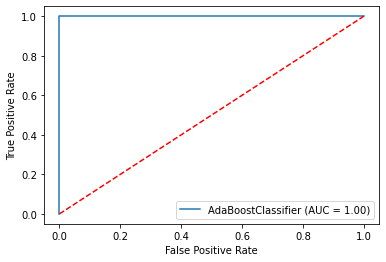

In [21]:
def display_roc_curve(model_name, roc_curve_data, roc_auc):
    """[summary]

    Args:
        model_name ([type]): [description]
        roc_curve_data ([type]): [description]
        roc_auc ([type]): [description]
    """
    fpr, tpr, thresholds = roc_curve_data
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name = model_name)
    display.plot()
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.show()
    

display_roc_curve(df_test.iloc[0]['Modelo'], df_test.iloc[0]['roc_curve_data'], df_test.iloc[0]['auc'])

## Parte III: Clasificación y Regularización
El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona es o no pobre utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder cuánto ganan. Esta vez lo haremos con la base unida de las preguntas de la encuesta de hogar y la encuesta individual. A su vez, incluiremos ejercicios de regularización y de validación cruzada

1. Eliminen de ambas bases (`respondieron`, `norespondieron`) todas las variables relacionadas a ingresos (en el archivo `codigos_eph.pdf` ver las categorías: ingresos de la ocupación principal de los asalariados, ingresos de la ocupación principal, ingresos de otras ocupaciones, ingreso total individual, ingresos no laborales, ingreso total familiar, ingreso per cápita familiar). Elimine también las columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario. Establezca a pobre como su variable dependiente (vector y). El resto de las variables serán las variables independientes (matriz X). Dependiendo de la función que usen, no se olviden de agregar la columna de 1 cuando sea necesario.


In [23]:
# Creamos dos nuevos dataframes (uno por base) donde eliminamos las columnas con valores relacionados a
# ingresos y los ponderadores asociados.
respondieronII = respondieron
norespondieronII = norespondieron

respondieronII.drop(['ITF_x', 'PP06C', 'PP06D', 'PP08D1', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2'],
                    axis='columns', inplace=True)
respondieronII.drop(['ITF_y', 'DECIFR_y', 'ADECIFR_y', 'RDECIFR_y',
                    'PDECIFR_y', 'GDECIFR_y', 'IPCF_y'], axis='columns', inplace=True)
respondieronII.drop(['PP08J3', 'P21', 'PONDIIO', 'TOT_P12', 'P47T', 'PONDII', 'V2_M', 'V3_M'],
                    axis='columns', inplace=True)
respondieronII.drop(['V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M',
                    'V11_M'], axis='columns', inplace=True)
respondieronII.drop(['V12_M', 'V18_M', 'V19_AM', 'V21_M',
                    'T_VI', 'IPCF_x'], axis='columns', inplace=True)
# Luego eliminamos las variables en escalas decílicas

respondieronII.drop(['DECINDR', 'ADECINDR', 'PDECINDR', 'GDECINDR', 'IDECINDR', 'DECOCUR', 'ADECOCUR', 'RDECOCUR'],
                    axis='columns', inplace=True)
respondieronII.drop(['PDECOCUR', 'GDECOCUR', 'IDECOCUR', 'DECIFR_x', 'ADECIFR_x', 'RDECIFR_x', 'PDECIFR_x', 'GDECIFR_x'],
                    axis='columns', inplace=True)
respondieronII.drop(['IDECIFR_x', 'DECCFR_x', 'ADECCFR_x', 'RDECCFR_x', 'PDECCFR_x', 'GDECCFR_x', 'IDECCFR_x', 'RDECINDR'],
                    axis='columns', inplace=True)
respondieronII.drop(['IDECIFR_y', 'DECCFR_y', 'ADECCFR_y', 'RDECCFR_y', 'PDECCFR_y', 'GDECCFR_y', 'IDECCFR_y'],
                    axis='columns', inplace=True)
# Finalmente elimianamos las columnas generadas en el Punto I.
respondieronII.drop(['Adulto_equiv', 'ad_equiv_hogar',
                    'ingreso_necesario'], axis='columns', inplace=True)

# Repetimos para la segunda base
norespondieronII.drop(['ITF_x', 'PP06C', 'PP06D', 'PP08D1', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2'],
                      axis='columns', inplace=True)
norespondieronII.drop(['ITF_y', 'DECIFR_y', 'ADECIFR_y', 'RDECIFR_y',
                      'PDECIFR_y', 'GDECIFR_y', 'IPCF_y'], axis='columns', inplace=True)
norespondieronII.drop(['PP08J3', 'P21', 'PONDIIO', 'TOT_P12', 'P47T', 'PONDII', 'V2_M', 'V3_M'],
                      axis='columns', inplace=True)
norespondieronII.drop(['V4_M', 'V5_M', 'V8_M', 'V9_M',
                      'V10_M', 'V11_M'], axis='columns', inplace=True)
norespondieronII.drop(['V12_M', 'V18_M', 'V19_AM', 'V21_M',
                      'T_VI', 'IPCF_x'], axis='columns', inplace=True)
# Luego eliminamos las variables en escalas decílicas

norespondieronII.drop(['DECINDR', 'ADECINDR', 'PDECINDR', 'GDECINDR', 'IDECINDR', 'DECOCUR', 'ADECOCUR', 'RDECOCUR'],
                      axis='columns', inplace=True)
norespondieronII.drop(['PDECOCUR', 'GDECOCUR', 'IDECOCUR', 'DECIFR_x', 'ADECIFR_x', 'RDECIFR_x', 'PDECIFR_x', 'GDECIFR_x'],
                      axis='columns', inplace=True)
norespondieronII.drop(['IDECIFR_x', 'DECCFR_x', 'ADECCFR_x', 'RDECCFR_x', 'PDECCFR_x', 'GDECCFR_x', 'IDECCFR_x', 'RDECINDR'],
                      axis='columns', inplace=True)
norespondieronII.drop(['IDECIFR_y', 'DECCFR_y', 'ADECCFR_y', 'RDECCFR_y', 'PDECCFR_y', 'GDECCFR_y', 'IDECCFR_y'],
                      axis='columns', inplace=True)
# Finalmente elimianamos las columnas generadas en el Punto I.
norespondieronII.drop(['Adulto_equiv', 'ad_equiv_hogar',
                      'ingreso_necesario'], axis='columns', inplace=True)


KeyError: "['ITF_x' 'PP06C' 'PP06D' 'PP08D1' 'PP08F1' 'PP08F2' 'PP08J1' 'PP08J2'] not found in axis"

In [25]:
y = respondieron.pobre
X = respondieron.drop("pobre", axis=1)

2. Corran la función `multiples_metodos` con la base respondieron. En los próximos incisos profundizaremos en la tarea de regularización, pero en este ejercicio prueben al menos un hiperparámetro para regularizar y al menos un valor de λ. 

In [26]:
punto_2=evalua_multiples_metodos(X,y,model_list)
punto_2

  0%|          | 0/8 [00:00<?, ?it/s]

KeyError: "None of [Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,\n            ...\n            2518, 2520, 2521, 2522, 2524, 2525, 2526, 2527, 2528, 2529],\n           dtype='int64', length=2277)] are in the [columns]"

3. Expliquen cómo elegiría λ por validación cruzada. Detallen por qué no usarían el conjunto de prueba (test) para su elección

Para estimar el parámetro óptimo que penaliza la complejidad del modelo se itera a partir de distintas particiones. Luego, se observa bajo que valor del parámetro el modelo ajusta mejor según el promedio de la medida de precisión elegida (EMC, accuracy score, etc.).
En validación cruzada, al partir la muestra en distintas particiones, el conjunto de testeo no se utiliza, ya que es el que se utiliza para contrastar la precisión del modelo estimado a partir del conjunto de entrenamiento. De todas formas, cuando se itera, por ejemplo, con la función K-Fold, las particiones que antes se utilizaban como entrenamiento pasan luego a utilizarse al menos una vez como conjunto de testeo.

4. En validación cruzada, ¿cuál es el problema de usar un K muy pequeño y uno muy grande? y cuando K = n (con n el número de muestras), ¿cuántas veces se estima el modelo?

Un K muy grande implica un problema de Overfit. Si bien K aumenta la complejidad y tiende el sesgo a cero,
dado que el sesgo del modelo deja de reducirse luego de un K lo suficientemente alto y que la varianza no
cesa de aumentar, el modelo comienza a perder validez externa. Por otro lado, si K=n y n es el número de 
muestras, el modelo se estimará Kxn veces para el error de pronóstico y una sola vez para los coeficientes.

5. Realicen un barrido en λ = $10^n$ con n ∈ {−5, −4, −3..., +4, +5} y utilicen 10-fold CV para elegir el λ óptimo en regresión logística con Ridge y con LASSO. ¿Qué λ seleccionó en cada caso? Generen box-plots mostrando la distribución del error de predicción para cada λ. Cada box debe corresponder a un valor de λ y contener como observaciones el error medio de validación para cada partición. Además, para la regularización LASSO, genere un box-plot similar, pero ahora graficando la proporción de variables ignoradas por el modelo en función de λ, es decir la proporción de variables para las cuales el coeficiente asociado es cero. 

6. En el caso del valor óptimo de λ para LASSO encontrado en el inciso anterior,¿qué variables fueron descartadas? ¿Son las que hubieran esperado? ¿Tienerelación con lo que respondió en el inciso 1 de la Parte I?

7. Elijan alguno de los modelos de regresión logistica donde haya probado distintos parametros de regularización y comente: ¿Qué metodo de regularización funcionó mejor Ridge o LASSO? Comente mencionando el error cuadrático medio (ECM). 

8. Cuál de todos los métodos evaluados predice mejor? ¿Con qué hiperparámetros? Justifiquen detalladamente utilizando las medidas de precisión que conoce.

9. Con el método que seleccionó, predigan qué personas son pobres dentro de la base norespondieron. ¿Qué proporción de los hogares son pobres en esa submuestra? 